## <ins>IMPORT DES DEPENDANCES</ins>

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import pathlib
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from matplotlib import offsetbox
from matplotlib.image import imread
import tensorflow as tf
import cv2
import tqdm

2024-05-01 18:53:57.335769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 18:53:57.371218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <ins>CONSTRUCTION DU DATASET PERMETTANT DE CHARGER NOS IMAGES A PARTIR DE LEUS PATH</ins>

In [3]:
# LIEN DES DOSSIER TRAIN ET TEST CONTENANT NOS IMAGES
data_dir_train = pathlib.Path('./images/train')

data_dir_test = pathlib.Path('./images/test')

print("Nombre d'Images dossier train", end = "\n\n")
print(len(list(data_dir_train.glob('*.jpg'))), end = "\n\n")

print("Nombre d'Images dossier test", end = "\n\n")
print(len(list(data_dir_test.glob('*.jpg'))), end = "\n\n")

Nombre d'Images dossier train

84916

Nombre d'Images dossier test

13812



In [4]:
# Trouver tous les chemins vers les fichiers qui finissent par .jpg

liste_train = glob('./images/train/*jpg')
liste_test = glob('./images/test/*jpg')

# Remplacer les \\ par /
liste_train = list(map(lambda x : [x, x.split('/')[2]], liste_train))
liste_test = list(map(lambda x : [x, x.split('/')[2]], liste_test))

# Créer un DataFrame pandas
df_train = pd.DataFrame(liste_train, columns=['filepath', 'nameLabel'])
df_test = pd.DataFrame(liste_test, columns=['filepath', 'nameLabel'])

display(df_train.head())
display(df_test.head())

,filepath,nameLabel
0,./images/train/image_1000076039_product_580161...,train
1,./images/train/image_1000089455_product_348990...,train
2,./images/train/image_1000092894_product_353108...,train
3,./images/train/image_1000093804_product_343306...,train
4,./images/train/image_1000095646_product_344209...,train


,filepath,nameLabel
0,./images/test/image_1000095714_product_3453011...,test
1,./images/test/image_1000139370_product_3536368...,test
2,./images/test/image_1000221680_product_3536266...,test
3,./images/test/image_1000434342_product_3528824...,test
4,./images/test/image_1000524141_product_3576959...,test


### NETTOYAGE TEXTE COLONNE FILEPATH POUR LIER AVEC UN DATAFRAME LIEN IMAGE ID AUx LABELs

In [4]:
# TRAIN - Récupération de nos id et product pour joonction avec nos labels
df_train['filepath_1'] = df_train['filepath'].str.replace("./images/train/image_", "")
df_train['filepath_1'] = df_train['filepath_1'].str.replace("product_", "")
df_train['filepath_1'] = df_train['filepath_1'].str.replace(".jpg", "")
# CREATION D UNE COLONNE PRODUCTID ET D UNE IMAGE ID
df_train[['imageid','productid']] = df_train.filepath_1.str.split('_', expand=True)
df_train['imageid'] = df_train['imageid'].astype('int')
df_train = df_train.drop(['nameLabel', 'filepath_1'], axis =1)
display(df_train.head())
print("Shape du DF : ", df_train.shape[0])

,filepath,imageid,productid
0,/datas/images/train/image_1000076039_product_5...,1000076039,580161
1,/datas/images/train/image_1000089455_product_3...,1000089455,348990858
2,/datas/images/train/image_1000092894_product_3...,1000092894,353108104
3,/datas/images/train/image_1000093804_product_3...,1000093804,343306951
4,/datas/images/train/image_1000095646_product_3...,1000095646,344209267


Shape du DF :  84916


In [5]:
# LECTURE DE NOTRE DATASET DE LIAISON PERMETTANT AINSI DE LIER NOS IMAGES AVEC NOTRE VALEUR CIBLE
df_liaison = pd.read_csv('liaison_images_labels_clean.csv')
df_liaison.head()

,productid,imageid,prdtypecode,produit,langue
0,436067568,1008141237,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr
1,201115110,938777978,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr
2,50418756,457047496,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,en
3,278535884,1077757786,2705,La Guerre Des Tuques Luc a des id&eacute;es de...,fr
4,5862738,393356830,2280,Afrique Contemporaine N° 212 Hiver 2004 - Doss...,fr


In [6]:
# JONCTION DE NOTRE DATAFRAME DE LIAISON ET DE CELUI DE NOS ETIQUETTES
liste_train = pd.merge(left = df_train,
         right = df_liaison,
         left_on = 'imageid',
         right_on = 'imageid',
         how = 'inner')

print("Shape de notre dataset contenant nos filepath liés à nos labels :", liste_train.shape)

# Création d'une colonne label permettant de mettre nos labels entre 0 et 26 - utile cadre de l'entrainement
liste_train['label'] = liste_train['prdtypecode'].replace(liste_train.prdtypecode.unique(), [*range(len(liste_train.prdtypecode.unique()))])

liste_train = liste_train.drop(['productid_x','productid_y'], axis =1)

liste_train.head()

Shape de notre dataset contenant nos filepath liés à nos labels : (76167, 7)


,filepath,imageid,prdtypecode,produit,langue,label
0,/datas/images/train/image_1000076039_product_5...,1000076039,10,Télémaque - Je Ne Sais Quoi De Pur Et De Sublime,fr,0
1,/datas/images/train/image_1000089455_product_3...,1000089455,2280,Armées D'aujourd'hui 391 - 1914 Le Monde S'emb...,fr,1
2,/datas/images/train/image_1000092894_product_3...,1000092894,2403,Lot De 2 Mangas De La Série The Sacred Blacksm...,en,2
3,/datas/images/train/image_1000093804_product_3...,1000093804,1160,Phyllali Réverse 7/111 - Xy Poings Furieux,fr,3
4,/datas/images/train/image_1000095646_product_3...,1000095646,1160,Carte Pokemon Francaise Xy 3 Poings Furieux Sc...,fr,3


In [7]:
# liste_train.to_csv("df_multimodal_clean.csv", index= False)

## <ins>EXPLORATION DES IMAGES</ins>

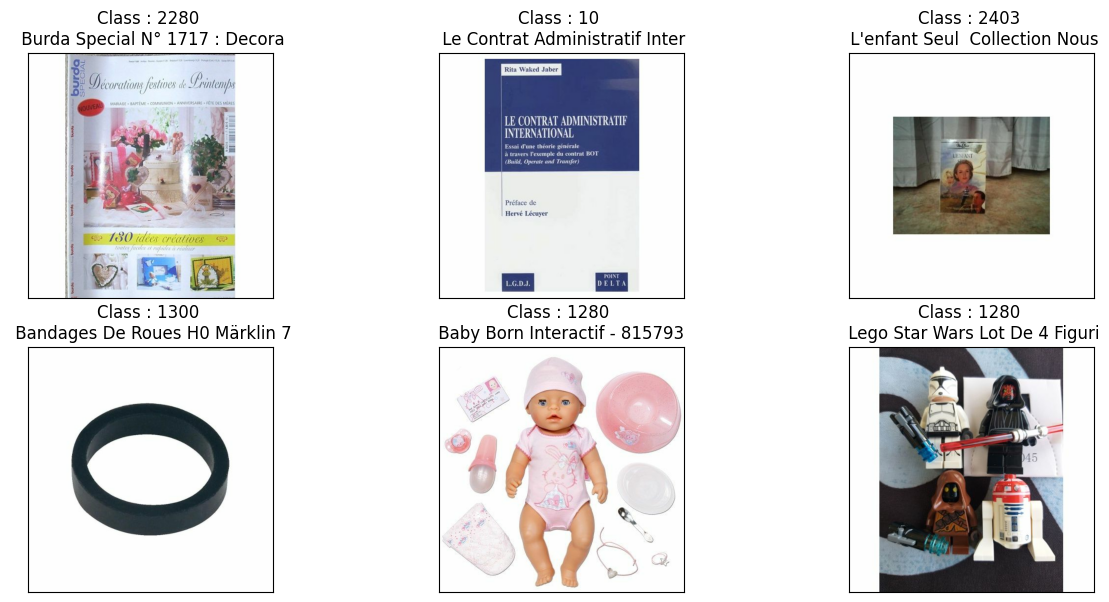

In [9]:
# Afficher trois images avec label et description

import tensorflow as tf

indices_random = np.random.uniform(0, len(liste_train), size= 6)
indices_random = np.int32(indices_random)

plt.figure(figsize=(15,7))

for i, idx in enumerate(indices_random):
    # Chemin de l'image
    filepath = liste_train.filepath[idx]
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    plt.subplot(2,3,i+1)
    plt.imshow(im)

    plt.xticks([])
    plt.yticks([])
    plt.title('Class : {} \n {}'.format(liste_train.prdtypecode[idx], liste_train.produit[idx][:30]))

## <ins>SUPPRESSION DU BLANC ENCADRANT LES IMAGES</ins>

In [10]:
from tqdm import tqdm
from PIL import Image


# Trouver le premier pixel non blanc dans une direction
def find_non_white_pixel(img, start, end, step):
    for i in range(start, end, step):
        if np.any(img[i] < 255):
            return i
    return end

src_dir = '/datas/images/'
dest_dir = '/datas/images/pretraitement'

# Bouclez sur les sous-répertoires dans le répertoire source
for subdir in tqdm(os.listdir(src_dir)):

    # Créez le sous-répertoire correspondant dans dest_dir
    os.makedirs(os.path.join(dest_dir, subdir), exist_ok=True)

    # Bouclez sur les fichiers dans le sous-répertoire
    print (subdir)
    
    for file in os.listdir(os.path.join(src_dir, subdir)):

        img_path = os.path.join(src_dir, subdir, file)

        img = cv2.imread(img_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Trouver le premier pixel non-blanc dans chaque direction
        top = find_non_white_pixel(gray, 0, gray.shape[0], 1)
        bottom = find_non_white_pixel(gray, gray.shape[0] - 1, -1, -1)
        left = find_non_white_pixel(gray.T, 0, gray.shape[1], 1)
        right = find_non_white_pixel(gray.T, gray.shape[1] - 1, -1, -1)

        # Rogner l'image pour l'adapter au rectangle englobant
        crop = img[top:bottom+1, left:right+1]

        if crop.size > 0:

            # Redimensionner l'image à sa taille d'origine
            original_height, original_width = img.shape[:2]
            resized_img = cv2.resize(crop, (original_width, original_height))

            # cv2.imwrite(os.path.join(dest_dir, subdir, file), resized_img)
            cv2.imwrite(os.path.join(dest_dir, subdir, file), resized_img)

  0%|          | 0/2 [00:00<?, ?it/s]

test


 50%|█████     | 1/2 [03:16<03:16, 196.71s/it]

train


100%|██████████| 2/2 [23:19<00:00, 699.89s/it]


## <ins>NOUVEAU DATASET AVEC PATH CORRESPONDANTS AUX IMAGES PRETRAITES</ins>

In [11]:
# LIEN DES DOSSIER TRAIN ET TEST CONTENANT NOS IMAGES
data_dir_train = pathlib.Path('/datas/images/pretraitement/train')

data_dir_test = pathlib.Path('/datas/images/pretraitement/test')

In [12]:
# Trouver tous les chemins vers les fichiers qui finissent par .jpg

liste_train = glob('/datas/images/pretraitement/train/*jpg')
liste_test = glob('/datas/images/pretraitement/test/*jpg')

# Remplacer les \\ par /
liste_train = list(map(lambda x : [x, x.split('/')[2]], liste_train))
liste_test = list(map(lambda x : [x, x.split('/')[2]], liste_test))

# Créer un DataFrame pandas
df_train = pd.DataFrame(liste_train, columns=['filepath', 'nameLabel'])
df_test = pd.DataFrame(liste_test, columns=['filepath', 'nameLabel'])

display(df_train.head())
display(df_test.head())

,filepath,nameLabel
0,/datas/images/pretraitement/train/image_100007...,images
1,/datas/images/pretraitement/train/image_100008...,images
2,/datas/images/pretraitement/train/image_100009...,images
3,/datas/images/pretraitement/train/image_100009...,images
4,/datas/images/pretraitement/train/image_100009...,images


,filepath,nameLabel
0,/datas/images/pretraitement/test/image_1000095...,images
1,/datas/images/pretraitement/test/image_1000139...,images
2,/datas/images/pretraitement/test/image_1000221...,images
3,/datas/images/pretraitement/test/image_1000434...,images
4,/datas/images/pretraitement/test/image_1000524...,images


In [13]:
# TRAIN - Récupération de nos id et product pour joonction avec nos labels
df_train['filepath_1'] = df_train['filepath'].str.replace("/datas/images/pretraitement/train/image_", "")
df_train['filepath_1'] = df_train['filepath_1'].str.replace("product_", "")
df_train['filepath_1'] = df_train['filepath_1'].str.replace(".jpg", "")
# CREATION D UNE COLONNE PRODUCTID ET D UNE IMAGE ID
df_train[['imageid','productid']] = df_train.filepath_1.str.split('_', expand=True)
df_train['imageid'] = df_train['imageid'].astype('int')
df_train = df_train.drop(['nameLabel', 'filepath_1'], axis =1)
display(df_train.head())
print("Shape du DF : ", df_train.shape[0])

,filepath,imageid,productid
0,/datas/images/pretraitement/train/image_100007...,1000076039,580161
1,/datas/images/pretraitement/train/image_100008...,1000089455,348990858
2,/datas/images/pretraitement/train/image_100009...,1000092894,353108104
3,/datas/images/pretraitement/train/image_100009...,1000093804,343306951
4,/datas/images/pretraitement/train/image_100009...,1000095646,344209267


Shape du DF :  84912


In [14]:
# LECTURE DE NOTRE DATASET DE LIAISON PERMETTANT AINSI DE LIER NOS IMAGES AVEC NOTRE VALEUR CIBLE
df_liaison = pd.read_csv('liaison_images_labels_clean.csv')
# JONCTION DE NOTRE DATAFRAME DE LIAISON ET DE CELUI DE NOS ETIQUETTES
liste_train = pd.merge(left = df_train,
         right = df_liaison,
         left_on = 'imageid',
         right_on = 'imageid',
         how = 'inner')

print("Shape de notre dataset contenant nos filepath liés à nos labels :", liste_train.shape)

# Création d'une colonne label permettant de mettre nos labels entre 0 et 26 - utile cadre de l'entrainement
liste_train['label'] = liste_train['prdtypecode'].replace(liste_train.prdtypecode.unique(), [*range(len(liste_train.prdtypecode.unique()))])

liste_train = liste_train.drop(['productid_x','productid_y'], axis =1)

display(liste_train.head())

Shape de notre dataset contenant nos filepath liés à nos labels : (76163, 7)


,filepath,imageid,prdtypecode,produit,langue,label
0,/datas/images/pretraitement/train/image_100007...,1000076039,10,Télémaque - Je Ne Sais Quoi De Pur Et De Sublime,fr,0
1,/datas/images/pretraitement/train/image_100008...,1000089455,2280,Armées D'aujourd'hui 391 - 1914 Le Monde S'emb...,fr,1
2,/datas/images/pretraitement/train/image_100009...,1000092894,2403,Lot De 2 Mangas De La Série The Sacred Blacksm...,en,2
3,/datas/images/pretraitement/train/image_100009...,1000093804,1160,Phyllali Réverse 7/111 - Xy Poings Furieux,fr,3
4,/datas/images/pretraitement/train/image_100009...,1000095646,1160,Carte Pokemon Francaise Xy 3 Poings Furieux Sc...,fr,3


In [15]:
liste_train.to_csv("df_multimodal_clean.csv", index= False)

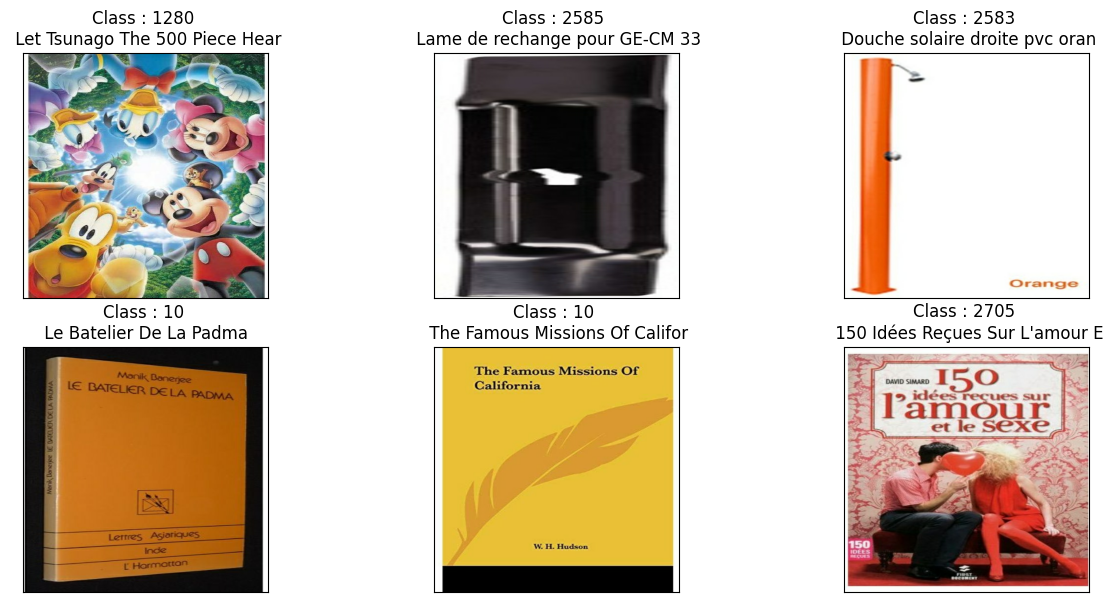

In [16]:
# Afficher trois images avec label et description

import tensorflow as tf

indices_random = np.random.uniform(0, len(liste_train), size= 6)
indices_random = np.int32(indices_random)

plt.figure(figsize=(15,7))

for i, idx in enumerate(indices_random):
    # Chemin de l'image
    filepath = liste_train.filepath[idx]
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    plt.subplot(2,3,i+1)
    plt.imshow(im)

    plt.xticks([])
    plt.yticks([])
    plt.title('Class : {} \n {}'.format(liste_train.prdtypecode[idx], liste_train.produit[idx][:30]))

In [17]:
df_texte = pd.read_csv('df_texte_clean.csv')

df_texte.head()

,Unnamed: 0,productid,imageid,prdtypecode,langue,produit_clean
0,0,436067568,1008141237,2280,french,journal art 2001 art marche salon art asiatiqu...
1,1,201115110,938777978,50,french,grand stylet ergonomique bleu gamepad nintendo...
2,2,50418756,457047496,1280,english,peluche donald europe disneyland 2000 marionne...
3,3,278535884,1077757786,2705,french,guerre tuques luc idées grandeur veut organise...
4,4,5862738,393356830,2280,french,afrique contemporaine hiver 2004 dossier japon...


In [20]:
df_multimodal_final = pd.merge(left = liste_train,
         right = df_texte,
         left_on = 'imageid',
         right_on = 'imageid',
         how = 'inner')

df_multimodal_final = df_multimodal_final[['filepath','imageid','prdtypecode_x','label','productid','produit_clean']]

df_multimodal_final.head()

,filepath,imageid,prdtypecode_x,label,productid,produit_clean
0,/datas/images/pretraitement/train/image_100007...,1000076039,10,0,580161,télémaque sais quoi pur sublime
1,/datas/images/pretraitement/train/image_100008...,1000089455,2280,1,348990858,armées aujourd hui 1914 monde embrase
2,/datas/images/pretraitement/train/image_100009...,1000092894,2403,2,353108104,lot mangas série sacred blacksmith
3,/datas/images/pretraitement/train/image_100009...,1000093804,1160,3,343306951,phyllali réverse poings furieux
4,/datas/images/pretraitement/train/image_100009...,1000095646,1160,3,344209267,carte pokemon francaise poings furieux scarhino


In [24]:
df_multimodal_final.to_csv('df_multimodal_final.csv')

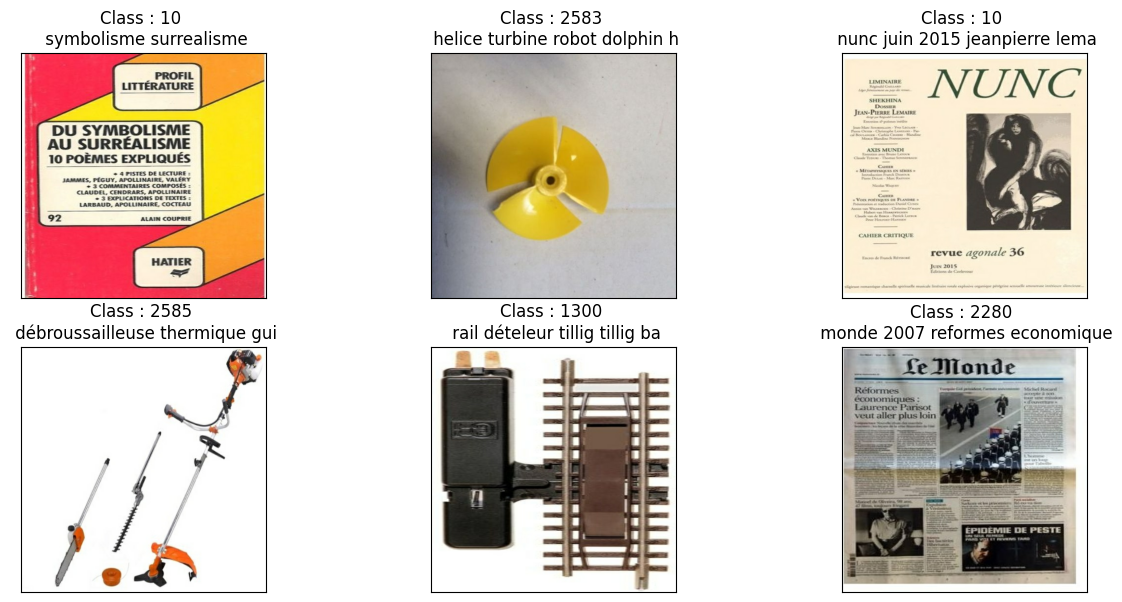

In [23]:
indices_random = np.random.uniform(0, len(liste_train), size= 6)
indices_random = np.int32(indices_random)

plt.figure(figsize=(15,7))

for i, idx in enumerate(indices_random):
    # Chemin de l'image
    filepath = df_multimodal_final.filepath[idx]
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    plt.subplot(2,3,i+1)
    plt.imshow(im)

    plt.xticks([])
    plt.yticks([])
    plt.title('Class : {} \n {}'.format(df_multimodal_final.prdtypecode_x[idx], df_multimodal_final.produit_clean[idx][:30]))